In [1]:
import numpy as np
from matplotlib import pyplot as plt
from src.communications_module.ofdm_modulator import OFDMModulator
from src.communications_module.channels.comm_channel import ChannelModel

In [2]:
rx_snrs_list = [-5, 0, 5]
subcarriers = 128
num_pilots = 8
bits_per_sym = 6
cp_ratio = 4

In [8]:
fading_channel = ChannelModel(total_carriers_over_ch=subcarriers,
                              channel_type='rician_fading',
                              scaled_ch=False,
                              number_paths=7,
                              fc=2380e6,
                              velocity=80,
                              sim_sample_rante=1e6,
                              k_rice=0,
                              r_hat_rice=1.1)
fading_channel.ch_response

array([ 0.4291802 -0.19124194j,  0.99100551-0.46684989j,
       -0.40335373-0.49560608j, ..., -0.63540298+0.4349081j ,
        0.20390903-0.6385345j , -0.36276011-0.04654296j])

In [4]:
ofdm_gen = OFDMModulator(bits_per_sym=bits_per_sym, 
                         subcarriers=subcarriers, 
                         cp_ratio_numitor=cp_ratio, 
                         num_pilots=num_pilots, 
                         rx_snr=rx_snrs_list,
                         fading_channel=fading_channel)

allCarriers:   [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
pilotCarriers: [  0  16  32  48  64  80  96 112 127]
dataCarriers:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  97  98  99 100 101 102 103 10

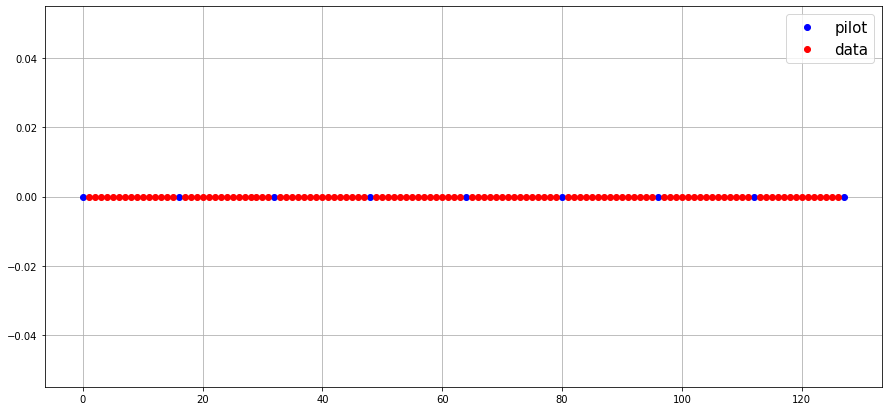

In [6]:
print ("allCarriers:   %s" % ofdm_gen.subcarriers_idxs)
print ("pilotCarriers: %s" % ofdm_gen.pilots_idxs)
print ("dataCarriers:  %s" % ofdm_gen.data_carriers_idxs)
plt.figure(figsize=(15, 7))
plt.plot(ofdm_gen.pilots_idxs, np.zeros_like(ofdm_gen.pilots_idxs), 'bo', label='pilot')
plt.plot(ofdm_gen.data_carriers_idxs, np.zeros_like(ofdm_gen.data_carriers_idxs), 'ro', label='data')
plt.legend(prop={'size': 15})
plt.grid()

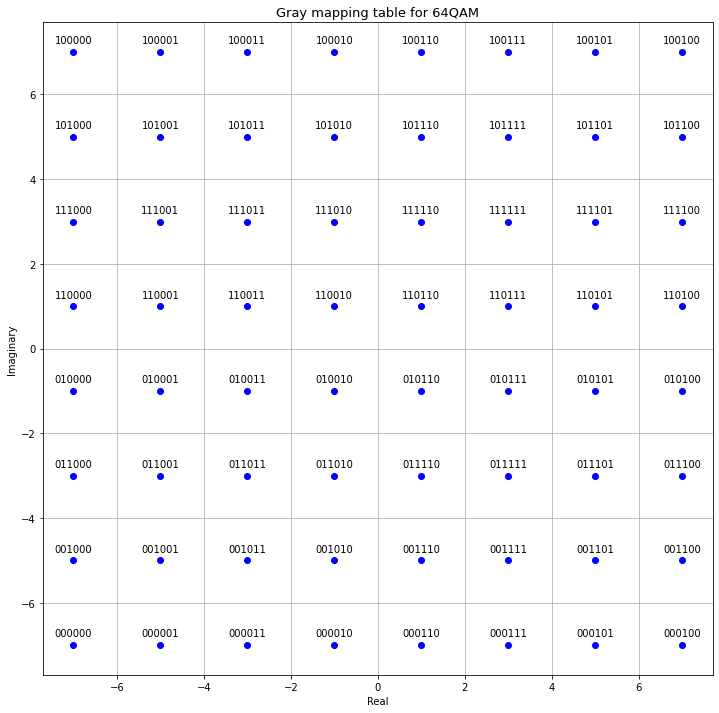

In [7]:
plt.figure(figsize=(12, 12))
plt.grid()
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title(f'Gray mapping table for {2**bits_per_sym}QAM', fontsize=13)
for key in ofdm_gen.mapping_table.keys():
    Q = ofdm_gen.mapping_table[key]
    plt.plot(Q.real, Q.imag, 'bo')
    plt.text(Q.real, Q.imag+0.2, "".join(str(key)), ha='center')

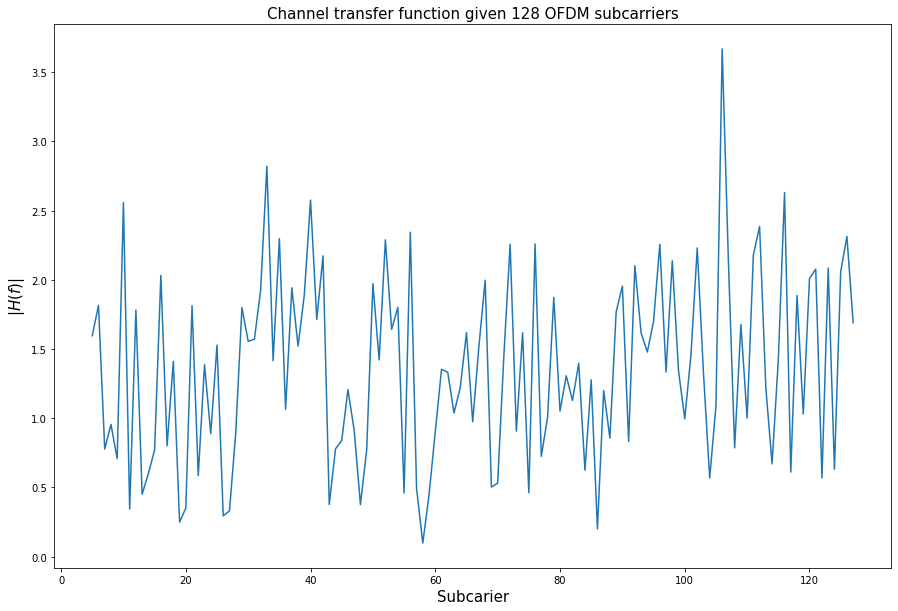

In [112]:
channelResponse = ofdm_gen.channel_response  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, ofdm_gen.subcarriers)
plt.figure(figsize=(15,10))
plt.plot(ofdm_gen.subcarriers_idxs[5:], abs(H_exact)[5:])
plt.xlabel('Subcarier', fontsize=15); plt.ylabel('$|H(f)|$', fontsize=15);
plt.title(f'Channel transfer function given {subcarriers} OFDM subcarriers', fontsize=15)
SNRdb = 25  # signal to noise-ratio in dB at the receiver 

In [50]:
ofdm_sign = np.array([])
for i in range(200):
    payload, flag = ofdm_gen.generate_payload()
    print(payload, flag)
    qam_load = ofdm_gen.map_words_2_qam(payload)
    ofdm_sym = ofdm_gen.ofdm_symbol(qam_load, flag)
    ofdm_ift = ofdm_gen.ofdm_idft(ofdm_sym)
    if not flag:
        ofdm_wcp = ofdm_gen.add_cyclic_prefix(ofdm_ift)
        ofdm_sign = np.append(ofdm_wcp, ofdm_sign, 0)
    else:
        ofdm_sign = np.append(ofdm_ift, ofdm_sign, 0)
    # qam_load
print(ofdm_sign)

[[1 1 1 0 0 1]
 [0 1 1 1 0 1]
 [1 0 1 0 0 1]
 [0 0 0 1 1 0]
 [1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [0 0 1 0 1 0]
 [1 0 1 1 1 1]
 [1 0 0 1 1 1]
 [0 0 1 1 0 0]
 [0 0 0 0 1 1]
 [1 1 1 0 1 1]
 [1 0 0 0 0 1]
 [0 1 0 0 0 1]
 [1 0 1 0 1 0]
 [1 1 0 1 0 1]
 [1 1 1 0 1 1]
 [1 1 1 1 0 1]
 [1 1 1 1 0 1]
 [1 1 0 1 0 0]
 [1 0 0 1 1 1]
 [0 0 1 1 1 1]
 [1 1 0 1 1 0]
 [1 1 1 0 1 1]
 [0 1 0 1 1 1]
 [0 1 1 0 1 1]
 [1 0 1 1 0 0]
 [1 0 0 0 1 1]
 [1 0 0 0 1 1]
 [0 1 1 1 0 1]
 [1 0 1 1 0 0]
 [0 0 1 1 1 0]
 [1 0 1 0 1 1]
 [1 0 1 0 1 0]
 [0 1 1 0 0 0]
 [1 1 0 1 1 0]
 [0 1 0 0 1 0]
 [0 1 1 1 1 0]
 [0 0 1 0 1 0]
 [0 1 0 0 0 1]
 [0 1 0 1 1 0]
 [1 0 1 1 1 1]
 [0 0 0 0 0 0]
 [0 1 0 0 0 1]
 [1 0 0 1 1 0]
 [1 0 1 1 1 1]
 [0 0 0 1 0 1]
 [0 1 0 1 1 1]
 [0 1 0 0 1 0]
 [1 0 1 0 0 1]
 [0 1 0 0 0 1]
 [1 0 1 0 1 1]
 [0 0 1 1 1 1]
 [0 1 0 1 0 1]
 [0 1 0 0 0 1]] 1
[[1 0 0 1 0 0]
 [0 0 1 0 0 1]
 [1 0 1 1 0 1]
 [0 0 1 0 0 0]
 [0 1 0 1 0 1]
 [1 1 0 0 0 1]
 [1 0 1 0 0 1]
 [0 0 1 1 1 1]
 [0 1 1 0 0 0]
 [0 1 0 1 1 1]
 [1 0 0 0 1 0]
 [0 0 0

 [1 1 1 1 1 1]] 0
[[1 0 1 0 1 0]
 [1 1 0 1 1 0]
 [1 1 0 1 0 1]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [1 1 1 0 0 0]
 [1 0 0 0 0 1]
 [1 1 0 1 1 1]
 [1 1 0 0 0 0]
 [1 1 0 0 1 1]
 [1 0 1 0 1 0]
 [0 0 0 1 1 1]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [0 1 0 1 0 0]
 [1 1 1 1 1 0]
 [0 0 1 1 1 1]
 [1 1 1 1 0 0]
 [1 0 1 1 0 1]
 [0 0 0 0 0 1]
 [0 1 0 1 0 0]
 [1 0 0 0 1 1]
 [0 1 1 0 0 0]
 [0 0 1 1 1 0]
 [1 0 1 1 0 0]
 [1 1 0 1 0 0]
 [1 0 1 1 1 0]
 [1 1 1 1 1 1]
 [1 0 1 1 0 1]
 [1 1 0 1 0 1]
 [1 0 0 1 1 1]
 [1 1 1 0 1 0]
 [1 0 0 0 0 1]
 [0 1 1 0 1 0]
 [1 0 1 1 1 1]
 [0 0 0 1 0 0]
 [1 0 0 1 0 0]
 [1 1 0 1 1 0]
 [0 1 0 1 0 1]
 [0 0 1 1 0 1]
 [0 1 0 1 0 1]
 [0 0 0 1 1 1]
 [0 0 1 0 1 1]
 [0 1 0 1 1 1]
 [0 1 0 1 1 0]
 [0 0 1 1 0 0]
 [0 0 1 1 1 1]
 [0 1 1 1 1 1]
 [0 1 0 1 1 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 1]
 [1 0 0 1 0 1]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]] 0
[[1 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 1 1 1 1]
 [0 0 0 1 0 1]
 [0 1 1 1 0 1]
 [1 0 1 1 0 1]
 [0 0 0 0 0 0]
 [1 1 1 0 0 1]
 [0 1 0 0 1 1]
 [1 0 0 1 0 0]
 [0 

 [1 1 1 0 1 1]] 1
[[0 1 1 1 1 1]
 [0 1 0 0 0 0]
 [0 1 1 0 1 0]
 [0 0 1 1 0 0]
 [0 1 1 0 0 1]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [1 1 1 0 0 0]
 [1 1 1 1 1 1]
 [1 0 0 1 0 0]
 [1 0 0 1 0 1]
 [1 0 1 0 0 0]
 [0 0 0 1 1 1]
 [0 0 1 0 0 0]
 [0 0 1 1 1 0]
 [1 1 0 1 1 0]
 [0 0 1 1 0 1]
 [0 0 1 0 0 0]
 [0 0 1 0 1 0]
 [0 0 0 0 0 1]
 [0 1 0 0 1 1]
 [1 0 1 1 1 1]
 [0 1 0 0 1 0]
 [1 1 1 1 1 1]
 [1 1 0 1 0 0]
 [1 0 1 1 0 1]
 [1 0 0 0 1 0]
 [1 1 1 0 0 0]
 [1 0 1 0 0 0]
 [1 1 0 0 0 0]
 [1 1 0 0 0 1]
 [1 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 1 0 0 1 0]
 [1 0 1 1 0 0]
 [0 0 1 0 1 0]
 [1 1 1 0 0 1]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 1 1]
 [0 1 1 1 1 0]
 [1 1 1 0 1 1]
 [1 0 1 1 0 1]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 1 0 0]
 [1 0 0 1 0 0]
 [0 0 1 1 1 0]
 [1 1 0 0 0 0]
 [0 1 0 1 0 1]
 [1 0 1 1 1 0]
 [0 1 0 1 0 1]
 [0 0 1 0 1 1]
 [0 0 1 0 0 1]
 [0 1 0 1 1 0]] 0
[[1 1 0 0 0 1]
 [1 0 1 1 1 1]
 [0 1 1 1 1 1]
 [0 1 0 1 0 0]
 [0 1 1 1 1 1]
 [0 0 0 0 1 0]
 [1 0 0 1 0 0]
 [1 1 0 1 1 0]
 [1 0 0 0 1 0]
 [1 1 1 1 1 0]
 [1 

In [55]:
ofdm_ift = ofdm_gen.ofdm_idft(ofdm_sign)
ofdm_wcp = ofdm_gen.add_cyclic_prefix(ofdm_ift)

In [56]:
OFDM_TX = ofdm_sign
OFDM_RX = ofdm_gen.ofdm_over_channel(OFDM_TX)

RX Signal power: 7.3010. Noise power: 0.0730


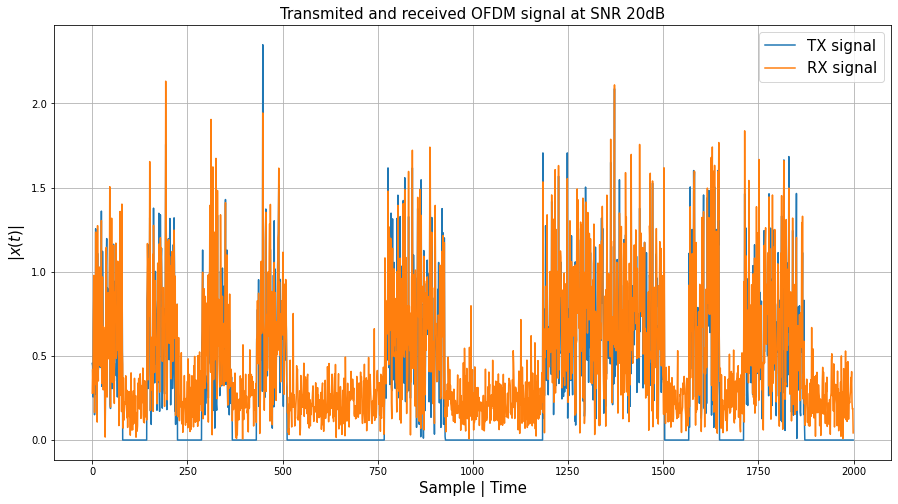

In [57]:
plt.figure(figsize=(15,8))
plt.title(f'Transmited and received OFDM signal at SNR {rx_snr}dB',
         fontsize=15)
plt.plot(abs(OFDM_TX[:2000]), label='TX signal')
plt.plot(abs(OFDM_RX[:2000]), label='RX signal')
plt.legend(fontsize=10, prop={'size': 15})
plt.xlabel('Sample | Time', fontsize=15); plt.ylabel('$|x(t)|$', fontsize=15);
plt.grid(True);

In [17]:
df['RX_OFDM'] = abs(OFDM_RX)
df['TX_OFDM'] = abs(OFDM_TX)
df.to_csv(f'E:/Faculta/Anul2/Sem1/ACP3/dataset/rx_tx_ofdm.csv')

In [14]:
import pandas as pd
df = pd.DataFrame()

In [15]:
for rx_snr in rx_snrs_list:
    ofdm_gen = OFDMModulator(bits_per_sym=bits_per_sym, 
                         subcarriers=subcarriers, 
                         cp_ratio_numitor=cp_ratio, 
                         num_pilots=num_pilots, 
                         rx_snr=rx_snr)
    ofdm_sign = np.array([])
    for i in range(100):
        payload, flag = ofdm_gen.generate_payload()
        print(payload, flag)
        qam_load = ofdm_gen.map_words_2_qam(payload)
        ofdm_sym = ofdm_gen.ofdm_symbol(qam_load, flag)
        ofdm_ift = ofdm_gen.ofdm_idft(ofdm_sym)
        ofdm_wcp = ofdm_gen.add_cyclic_prefix(ofdm_ift)
        ofdm_sign = np.append(ofdm_wcp, ofdm_sign, 0)
        # qam_load
    ofdm_ift = ofdm_gen.ofdm_idft(ofdm_sign)
    ofdm_wcp = ofdm_gen.add_cyclic_prefix(ofdm_ift)
    OFDM_TX = ofdm_sign
    OFDM_RX = ofdm_gen.ofdm_over_channel(OFDM_TX)
    df[f'{rx_snr}_TX_OFDM'] = abs(OFDM_TX)
    df[f'{rx_snr}_RX_OFDM'] = abs(OFDM_RX)
    
df.to_csv(f'E:/Faculta/Anul2/Sem1/ACP3/dataset/rx_tx_ofdm.csv', index=False)

[[1 0 0 1 1 0]
 [1 0 0 0 1 0]
 [0 0 0 0 0 0]
 [1 1 0 0 0 1]
 [0 1 0 1 1 0]
 [1 0 1 1 0 0]
 [1 0 0 0 0 1]
 [1 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 1 1]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 1 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]
 [1 1 0 0 0 0]
 [0 1 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [1 1 0 0 0 0]
 [0 0 0 0 1 0]
 [1 0 1 0 0 0]
 [0 0 1 0 1 1]
 [0 0 1 0 0 0]
 [0 1 0 1 0 1]
 [0 0 0 1 0 1]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [1 1 0 1 1 0]
 [0 0 0 1 0 0]
 [1 0 1 0 0 0]
 [0 0 0 0 1 1]
 [1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [0 1 0 1 1 0]
 [1 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [0 0 1 0 0 0]
 [1 0 1 0 0 1]
 [0 1 1 1 0 1]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 1 1 0 0]
 [0 0 1 0 1 0]
 [0 0 1 1 1 0]
 [0 0 0 0 0 1]
 [1 0 0 1 1 0]
 [1 0 0 1 0 0]
 [0 0 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 0 0 1 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 1]
 [0 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 1 0 0 

 [0 0 1 0 0 0]] 1
[[0 0 0 0 0 0]
 [1 0 1 1 0 1]
 [0 0 1 1 0 0]
 [1 1 1 0 1 0]
 [0 1 0 1 0 1]
 [0 1 0 0 0 1]
 [1 0 1 1 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 1 0]
 [0 1 0 1 1 0]
 [1 1 0 1 0 0]
 [1 0 1 0 1 0]
 [0 1 1 0 1 1]
 [0 0 0 0 1 1]
 [0 0 1 0 1 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 1 1 1 0 0]
 [0 0 0 1 0 1]
 [0 1 0 1 1 1]
 [0 0 0 1 0 1]
 [1 1 1 1 0 1]
 [0 0 1 1 1 0]
 [0 0 0 1 1 1]
 [1 0 0 1 0 0]
 [1 0 0 1 1 1]
 [0 1 1 0 0 1]
 [0 1 0 0 1 0]
 [0 1 1 0 1 1]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [0 1 0 0 1 0]
 [1 1 0 0 1 0]
 [1 0 1 1 0 0]
 [0 1 1 0 0 0]
 [1 0 0 1 0 0]
 [0 0 0 1 0 1]
 [1 0 0 0 0 0]
 [1 0 1 1 1 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 1]
 [1 1 0 0 1 1]
 [0 0 0 0 1 1]
 [0 0 0 1 0 1]
 [0 0 0 0 1 0]
 [0 0 0 0 1 1]
 [0 0 1 0 0 1]
 [0 0 0 1 0 1]
 [0 0 1 0 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 1 0]
 [1 0 0 1 1 0]
 [0 1 0 0 0 1]
 [0 1 0 1 1 0]
 [1 0 0 0 0 0]
 [0 1 1 1 0 1]
 [1 0 0 1 0 0]
 [0 0 1 0 1 1]
 [0 0 0 0 0 0]
 [1 1 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 1 0 1]
 [0 1 1 0 1 0]
 [0 1 0 0 0 0]
 [0 0 0

 [0 0 0 1 1 1]] 1
[[1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 1 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [1 0 0 1 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 1]
 [1 0 0 1 0 1]
 [0 1 1 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 1 0]
 [1 0 0 1 0 0]
 [1 0 1 1 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 1 1]
 [1 0 0 1 1 0]
 [0 0 1 0 0 0]
 [0 0 1 1 1 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 1]
 [0 0 1 0 0 1]
 [0 0 1 1 0 0]
 [0 0 0 1 0 0]
 [0 1 1 1 1 0]
 [0 0 0 1 0 0]
 [0 0 0 1 1 0]
 [0 0 1 0 0 0]
 [0 0 1 1 0 0]
 [1 0 0 0 0 0]
 [0 0 1 1 0 0]
 [0 1 1 0 1 0]
 [0 0 0 0 1 1]
 [1 1 0 0 1 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 1 0 0 1]
 [0 0 0 0 0 0]
 [0 1 0 1 0 0]
 [1 0 0 0 1 0]
 [1 1 0 0 1 0]
 [1 0 0 0 1 1]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 1 0 1 1 1]
 [1 0 1 0 0 0]
 [1 0 1 0 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 1]
 [1 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 1]
 [1 0 0 0 0 0]
 [0 1 1 1 1 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 1]
 [1 0 1

 [0 0 0 0 1 0]] 1
RX Signal power: 9.4080. Noise power: 0.3162
[[0 1 1 0 0 1]
 [0 0 0 0 1 0]
 [1 0 1 1 0 1]
 [0 1 0 0 0 1]
 [1 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [1 1 0 1 1 0]
 [0 0 0 1 0 0]
 [1 0 1 1 0 1]
 [0 0 0 0 1 0]
 [1 0 0 1 0 0]
 [0 1 0 0 0 1]
 [1 1 1 0 0 1]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 1 0 0 0]
 [0 0 0 0 1 1]
 [1 1 0 1 0 0]
 [0 0 0 1 1 0]
 [0 1 0 1 0 1]
 [0 0 0 0 0 1]
 [1 0 0 1 0 0]
 [1 0 1 1 1 0]
 [1 0 1 0 0 1]
 [0 0 1 0 1 0]
 [1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 1 1 1 0]
 [1 0 1 0 0 1]
 [1 1 0 1 0 0]
 [1 1 0 1 0 0]
 [0 1 0 0 0 1]
 [0 0 0 0 1 0]
 [1 1 0 0 1 1]
 [0 1 0 0 1 1]
 [0 1 1 0 0 0]
 [1 0 1 1 0 1]
 [0 0 0 0 0 1]
 [1 1 0 0 1 0]
 [0 1 0 0 1 1]
 [0 0 1 1 0 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 1]
 [0 0 0 1 1 0]
 [0 1 1 0 1 0]
 [1 1 0 0 1 0]
 [0 1 1 0 0 0]
 [1 0 1 0 0 0]
 [0 0 0 1 1 0]
 [1 0 0 1 1 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 1]
 [0 0 1 0 0 1]
 [1 0 0 0 1 0]
 [0 0 1 0 1 0]
 [0 0 0 1 0 0]
 [0 1 0 1 0 0]
 [1 1 0

[[1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 0 1 1 0]
 [0 0 0 1 1 0]
 [0 0 0 0 0 0]
 [0 1 1 1 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 1 1 0]
 [1 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 1 1 1]
 [1 0 0 1 1 0]
 [0 0 0 0 1 0]
 [0 1 1 1 0 0]
 [0 0 1 0 0 1]
 [1 1 1 0 0 1]
 [0 1 0 0 0 1]
 [0 0 0 0 1 0]
 [1 1 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [1 1 0 1 1 1]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 1 0 1 1 0]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 1 0]
 [0 1 0 0 0 0]
 [0 1 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 1 0 1]
 [0 0 1 0 0 0]
 [1 0 0 1 1 1]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 1 0]
 [0 0 1 0 0 0]
 [1 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 1 1 0]
 [0 0 0 1 1 1]
 [0 0 1 0 0 0]
 [1 0 0 1 0 1]
 [0 1 0 1 0 0]
 [0 1 1 0 1 0]
 [0 1 1 1 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 1]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 1 0 0 0 1]
 [1 1 0 1 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 1 0 

[[0 1 1 1 0 1]
 [1 0 0 0 1 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 1 0]
 [1 1 0 0 0 1]
 [0 0 0 0 1 1]
 [0 1 1 1 0 1]
 [1 1 0 0 1 0]
 [0 0 0 1 1 1]
 [1 1 0 1 1 1]
 [1 1 1 0 1 0]
 [0 0 0 0 0 0]
 [0 1 1 0 0 0]
 [1 1 1 1 0 1]
 [0 0 0 0 1 0]
 [1 0 0 1 0 0]
 [1 0 1 1 0 1]
 [0 0 0 0 0 0]
 [0 0 1 0 0 1]
 [0 0 0 1 1 0]
 [1 0 1 0 0 0]
 [1 0 0 1 1 1]
 [0 1 0 0 0 1]
 [0 0 1 1 1 0]
 [0 0 1 0 1 0]
 [1 0 1 0 0 0]
 [1 0 0 0 1 1]
 [0 1 0 0 1 1]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 1 1 0 1]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 1 1 1]
 [1 0 0 0 1 1]
 [1 0 0 0 0 0]
 [1 0 1 1 1 0]
 [0 1 0 1 1 0]
 [0 0 0 0 1 0]
 [0 1 1 0 1 1]
 [0 0 0 0 0 0]
 [1 1 0 0 0 0]
 [0 1 0 1 0 1]
 [1 1 0 1 0 0]
 [1 0 0 0 0 1]
 [1 0 0 0 1 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [1 0 0 1 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 1 1 0 0]
 [0 0 1 1 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 1 0]
 [0 1 0 1 0 0]
 [1 0 0 1 1 0]
 [0 0 1 1 1 1]
 [0 1 0 1 1 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 1 0 1 1]
 [0 0 0 1 

[[0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 1 1 0 0]
 [1 0 1 0 1 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 1 0]
 [1 1 0 0 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 1 1]
 [0 1 0 1 0 0]
 [0 1 0 0 0 0]
 [1 1 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [1 0 0 0 1 0]
 [0 0 0 0 1 0]
 [1 0 0 1 0 1]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]
 [1 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 1]
 [1 0 0 0 1 1]
 [0 0 1 1 0 1]
 [0 0 0 1 0 1]
 [0 0 0 1 0 0]
 [0 0 1 1 0 0]
 [0 0 1 0 0 0]
 [1 1 1 0 0 0]
 [1 0 0 0 0 1]
 [1 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 1 1 0 1 0]
 [1 0 0 1 1 0]
 [0 0 1 1 0 1]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 1 1]
 [1 0 0 0 0 0]
 [0 0 1 1 0 0]
 [1 1 0 0 1 0]
 [0 0 0 0 0 1]
 [0 1 1 1 0 0]
 [0 1 1 1 0 0]
 [1 0 0 1 0 0]
 [0 0 1 0 1 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 1]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 

[[0 0 0 0 1 0]
 [0 0 0 1 0 1]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 1 0 1 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 0 0 1 0]
 [0 0 0 1 0 1]
 [0 0 1 1 1 1]
 [0 0 1 0 0 0]
 [0 0 1 0 1 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [1 1 1 0 0 0]
 [1 1 0 1 0 1]
 [0 0 0 0 0 0]
 [0 0 1 1 0 1]
 [0 0 1 0 0 0]
 [1 0 0 0 1 1]
 [1 0 0 0 1 1]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 1]
 [0 0 1 0 1 1]
 [1 1 0 0 1 0]
 [0 1 0 0 1 1]
 [0 0 0 1 0 1]
 [0 0 1 0 0 1]
 [0 1 1 0 0 0]
 [1 1 1 0 1 0]
 [0 0 1 1 0 1]
 [0 1 0 1 0 0]
 [0 0 0 0 1 1]
 [0 1 1 0 0 0]
 [0 0 0 0 1 1]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 1 1 0]
 [0 1 0 0 0 1]
 [0 1 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 1]
 [1 1 0 1 0 0]
 [0 1 0 0 1 0]
 [1 0 1 0 0 0]
 [1 1 0 0 0 1]
 [0 0 0 1 1 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [1 0 0 0 1 0]
 [0 0 0 0 1 1]
 [1 0 1 0 0 1]
 [1 1 0 0 0 0]
 [1 0 1 0 0 0]
 [0 1 1 1 0 1]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 1 

 [0 0 0 1 1 1]] 1
[[0 0 0 0 0 1]
 [1 0 0 1 1 0]
 [0 1 1 0 0 1]
 [0 0 1 1 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 1 0 1 0 0]
 [1 0 0 0 0 0]
 [0 1 0 1 1 0]
 [0 0 0 1 0 1]
 [0 0 0 1 0 0]
 [0 1 0 1 1 0]
 [1 1 0 0 1 1]
 [0 0 0 0 0 0]
 [1 0 1 0 0 1]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [0 0 1 1 1 0]
 [0 1 1 0 1 1]
 [1 0 1 1 0 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 1]
 [1 0 0 1 0 0]
 [1 1 1 0 0 0]
 [0 0 1 0 0 1]
 [0 1 1 0 1 0]
 [1 0 0 1 0 0]
 [1 0 0 0 1 1]
 [0 1 0 1 1 0]
 [1 0 0 0 0 0]
 [0 0 1 1 1 1]
 [0 1 1 0 0 1]
 [1 0 1 1 0 1]
 [1 1 1 1 0 0]
 [0 1 0 0 1 1]
 [0 1 0 0 0 1]
 [0 0 0 0 0 0]
 [1 0 1 0 1 0]
 [0 1 1 0 0 0]
 [0 1 1 0 0 0]
 [1 1 1 1 0 0]
 [1 0 0 0 1 1]
 [1 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 1 1 1 0 0]
 [1 1 0 0 0 0]
 [0 1 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 1 1]
 [0 0 0 0 0 1]
 [1 1 1 0 0 0]
 [0 1 0 1 0 0]
 [1 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 1]
 [1 0 0 1 1 0]
 [0 0 1 1 0 0]
 [1 0 0 1 0 1]
 [0 0 0 0 0 0]
 [0 1 1 0 1 1]
 [0 0 0

 [1 1 0 0 0 0]] 0
[[0 0 0 0 1 0]
 [0 0 1 1 1 0]
 [1 0 0 0 1 0]
 [0 0 0 0 0 0]
 [1 0 1 0 1 1]
 [0 0 1 0 1 1]
 [1 0 0 0 0 0]
 [1 0 0 1 0 0]
 [1 1 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 1 0 1 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 1]
 [0 0 0 0 0 0]
 [1 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 1 1 1 0]
 [0 0 0 0 1 0]
 [1 1 1 1 1 0]
 [0 1 0 0 1 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 1 0]
 [1 0 0 0 0 0]
 [1 1 1 1 0 0]
 [0 1 1 1 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [1 0 1 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 1 0]
 [0 1 0 0 0 1]
 [1 0 1 1 0 0]
 [0 1 1 0 1 1]
 [0 1 0 0 1 0]
 [0 0 1 0 0 0]
 [1 1 1 1 0 0]
 [0 0 0 1 1 1]
 [1 1 0 1 0 0]
 [0 0 0 0 1 1]
 [0 1 1 1 1 0]
 [1 0 0 1 1 1]
 [0 0 1 0 0 0]
 [0 1 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 1 0]
 [1 1 0 0 0 0]
 [0 0 0 1 0 0]
 [1 1 0 0 0 0]
 [1 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 1 1 0 0]
 [0 0 1 0 0 1]
 [0 0 0 0 0 0]
 [0 1 0 0 1 0]
 [0 0 0 0 1 1]
 [1 0 0 0 1 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 1 1 0 0 1]
 [0 0 1 0 0 0]
 [0 0 0